In [531]:
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from dotenv import load_dotenv

# импорт пакетов, необходимых для работы

In [532]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

resp = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_BEGIN})

# работа с переменными окружения

## Подготовка данных

Запрос данных по API

In [533]:
response_visits = r.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")

json_data = response_visits.json()
df_visits = pd.DataFrame(json_data)

# print(df_visits.head())

In [534]:
response_registrations = r.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")

json_data_registrations = response_registrations.json()
df_registrations = pd.DataFrame(json_data_registrations)

# print(df_registrations.head())

Обрабатка данных и подготовка таблицы с конверсиями

In [535]:
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
df_visits['date_group'] = df_visits['datetime'].dt.date

# Добавление столбца, в котором записана только дата (без времени), его название - date_group

In [536]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [537]:
filtered_df_visits = df_visits[~df_visits['user_agent'].str.contains('Bot')]

# print(filtered_df_visits)

# Удаление строк, в которых есть слово "bot"

In [538]:
df_visits_sorted = filtered_df_visits.sort_values(by=['visit_id', 'datetime'], ascending=[True, False])

# Оставляем только последние визиты для каждого visit_id
filtered_df_unique_visits = df_visits_sorted.drop_duplicates(subset='visit_id', keep='first')

# print(filtered_df_unique_visits)

In [539]:
df_visits_agg = filtered_df_unique_visits.groupby(['date_group', 'platform'])['visit_id'].count().reset_index()
# print(df_visits_agg)

# Группировка данных визитов по датам и платформам

In [540]:
df_registrations['datetime'] = pd.to_datetime(df_registrations['datetime'])
df_registrations['date_group'] = df_registrations['datetime'].dt.date

# Добавление столбца с датой (без времени) в датафрейме с регистрациями

In [541]:
df_registrations_agg = df_registrations.groupby(['date_group', 'platform'])['user_id'].count().reset_index()

# print(df_registrations_agg)

# Агрегация датафрейма с регистрациями

In [542]:
df_join = pd.merge(df_visits_agg, df_registrations_agg, left_on=['date_group', 'platform'], right_on=['date_group', 'platform'], how='left')
# print(df_join)

# Объединение двух датафреймов

In [543]:
df_join['conversion'] = round((df_join['user_id'] / df_join['visit_id']) * 100, 0)
# print(df_join)

# Подсчет конверсий

In [544]:
df_join = df_join.rename(columns={'visit_id': 'visits'})
df_join = df_join.rename(columns={'user_id': 'registrations'})

print(df_join)

# Переименование столбцов

     date_group platform  visits  registrations  conversion
0    2023-03-01  android      75           61.0        81.0
1    2023-03-01      ios      22           18.0        82.0
2    2023-03-01      web     279            8.0         3.0
3    2023-03-02  android      67           59.0        88.0
4    2023-03-02      ios      31           24.0        77.0
..          ...      ...     ...            ...         ...
589  2023-08-30      ios      66           40.0        61.0
590  2023-08-30      web    1227           34.0         3.0
591  2023-08-31  android      57           42.0        74.0
592  2023-08-31      ios      50           36.0        72.0
593  2023-08-31      web     721           46.0         6.0

[594 rows x 5 columns]


In [545]:
df_join.to_json("./conversion.json")

Обработка данных и подготовка табдицы с данными о рекламе

In [546]:
df_visits_date_agg = filtered_df_unique_visits.groupby('date_group')['visit_id'].count().reset_index()

df_registrations_date_agg = df_registrations.groupby('date_group')['user_id'].count().reset_index()

df_join_date = pd.merge(df_visits_date_agg, df_registrations_date_agg, left_on='date_group', right_on='date_group', how='inner')

df_join_date = df_join_date.rename(columns={'visit_id': 'visits'})
df_join_date = df_join_date.rename(columns={'user_id': 'registrations'})

print(df_join_date)

# Группировка данных визитов и регистраций по датам

     date_group  visits  registrations
0    2023-03-01     376             87
1    2023-03-02     613            106
2    2023-03-03     683            107
3    2023-03-04     729            159
4    2023-03-05     829            115
..          ...     ...            ...
179  2023-08-27     795             88
180  2023-08-28     635             83
181  2023-08-29    1268            143
182  2023-08-30    1328            101
183  2023-08-31     828            124

[184 rows x 3 columns]


In [547]:
df_ads = pd.read_csv("./ads.csv")

df_ads['date'] = pd.to_datetime(df_ads['date'])
df_ads['date_group'] = df_ads['date'].dt.date

# print(df_ads)

# Добавление столбца с датой (без времени) в датафрейме с регистрациями

In [548]:
df_ads_agg = df_ads.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()

# print(df_ads_agg)

# Группировка по дате и utm_campaign, суммирование затрат по дням

In [549]:
df_join_ads = pd.merge(df_join_date, df_ads_agg, left_on='date_group', right_on='date_group', how='left')

print(df_join_ads)

# Объединение таблицы с данными визитов и регистраций с таблицей расходов на рекламу

     date_group  visits  registrations                utm_campaign   cost
0    2023-03-01     376             87  advanced_algorithms_series  212.0
1    2023-03-02     613            106  advanced_algorithms_series  252.0
2    2023-03-03     683            107  advanced_algorithms_series  202.0
3    2023-03-04     729            159  advanced_algorithms_series  223.0
4    2023-03-05     829            115  advanced_algorithms_series  265.0
..          ...     ...            ...                         ...    ...
179  2023-08-27     795             88      intro_to_python_course  222.0
180  2023-08-28     635             83      intro_to_python_course  223.0
181  2023-08-29    1268            143      intro_to_python_course  190.0
182  2023-08-30    1328            101      intro_to_python_course  109.0
183  2023-08-31     828            124      intro_to_python_course  215.0

[184 rows x 5 columns]


In [550]:
df_join_ads.to_json("./ads.json")

## Визаулизация

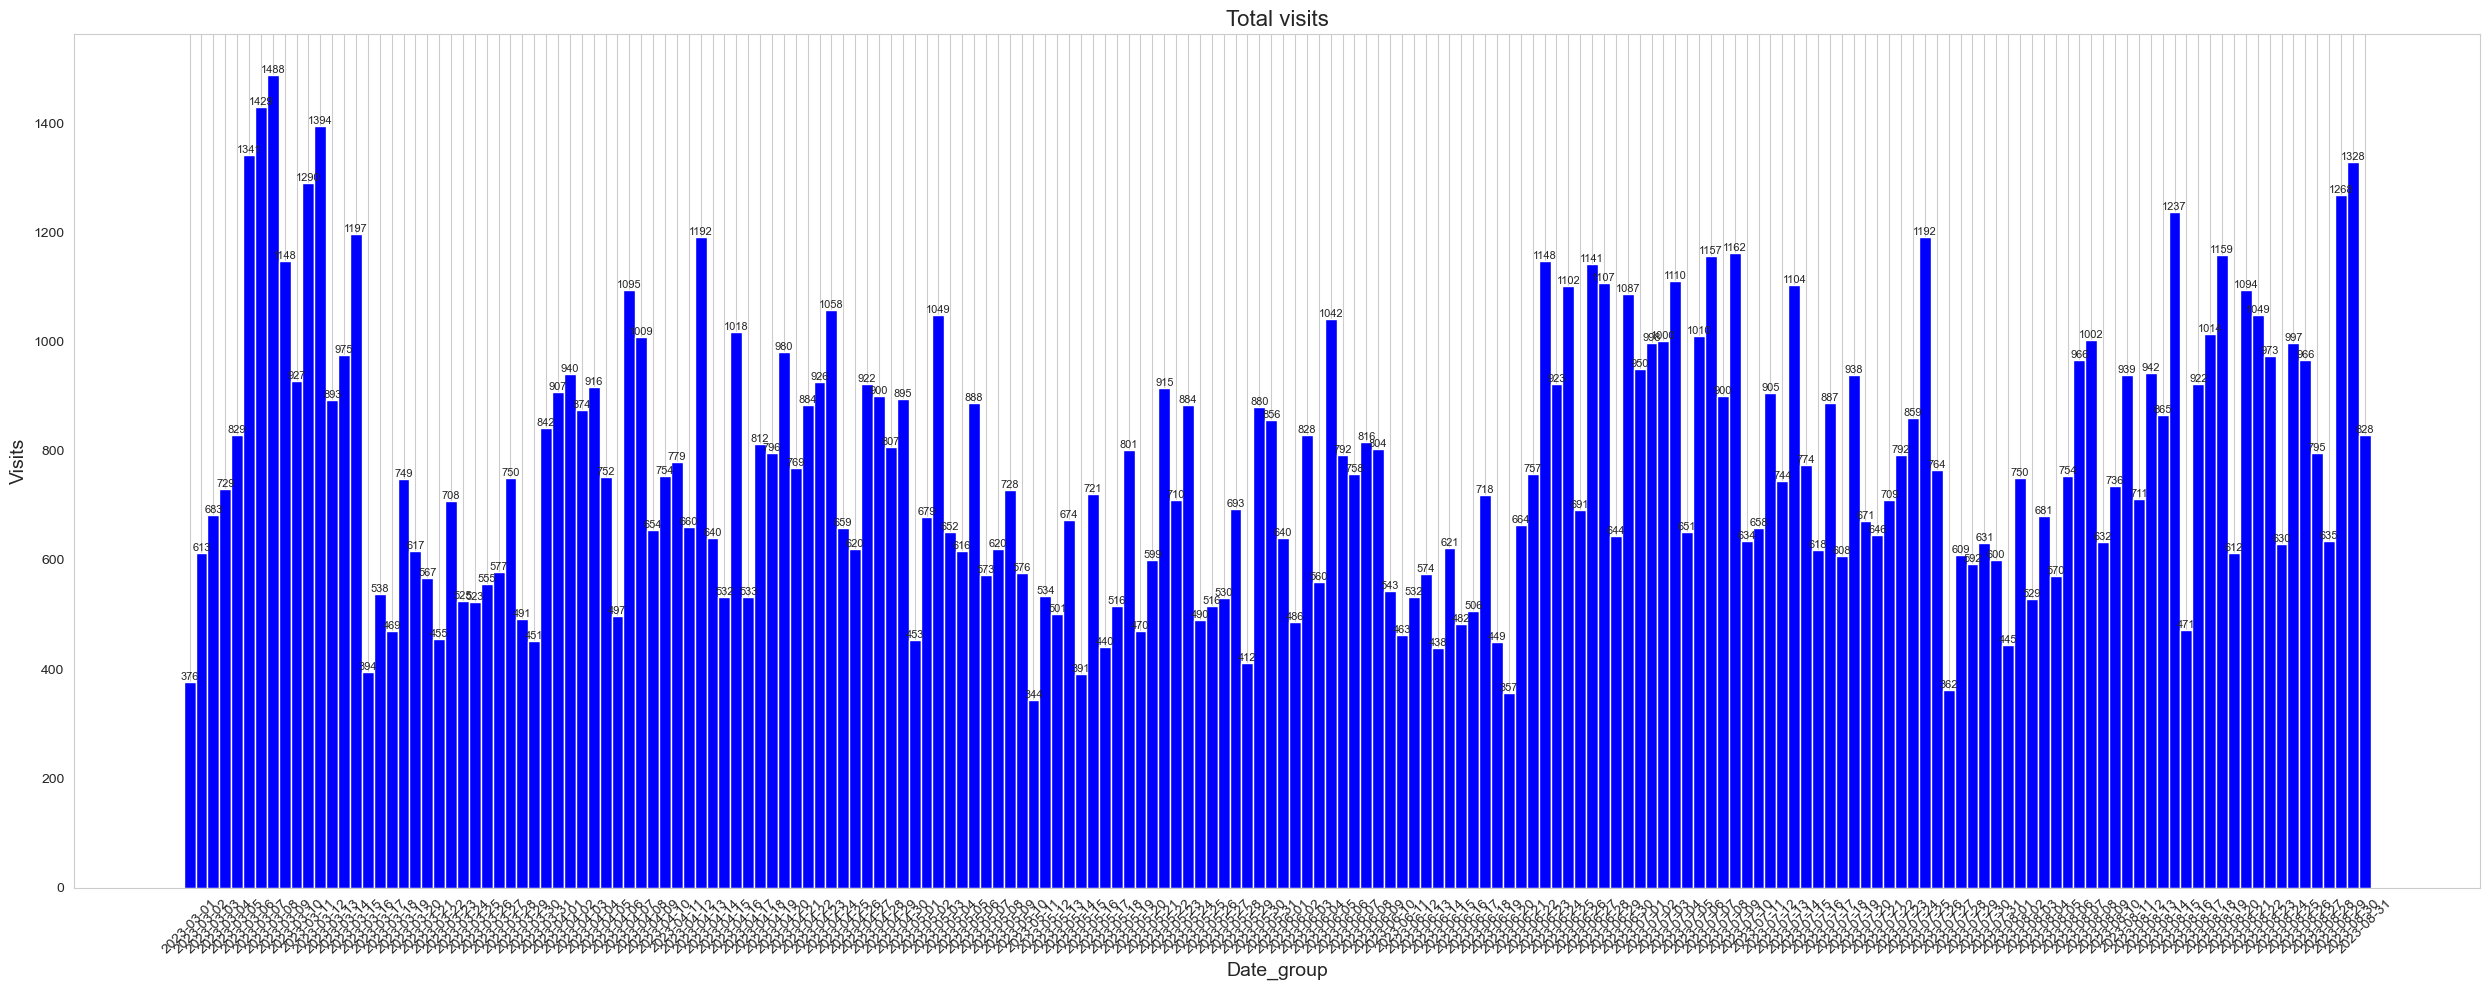

In [551]:
fig, ax = plt.subplots(figsize=(25,10))
bars = plt.bar(x='date_group', height='visits', data=df_join_ads, width=1, color='blue')
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('Total visits', fontsize=16)
plt.xlabel('Date_group', fontsize=14)
plt.ylabel('Visits', fontsize=14)
plt.xticks(df_join_ads['date_group'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("./charts/total_visits.png")

# Итоговые визиты


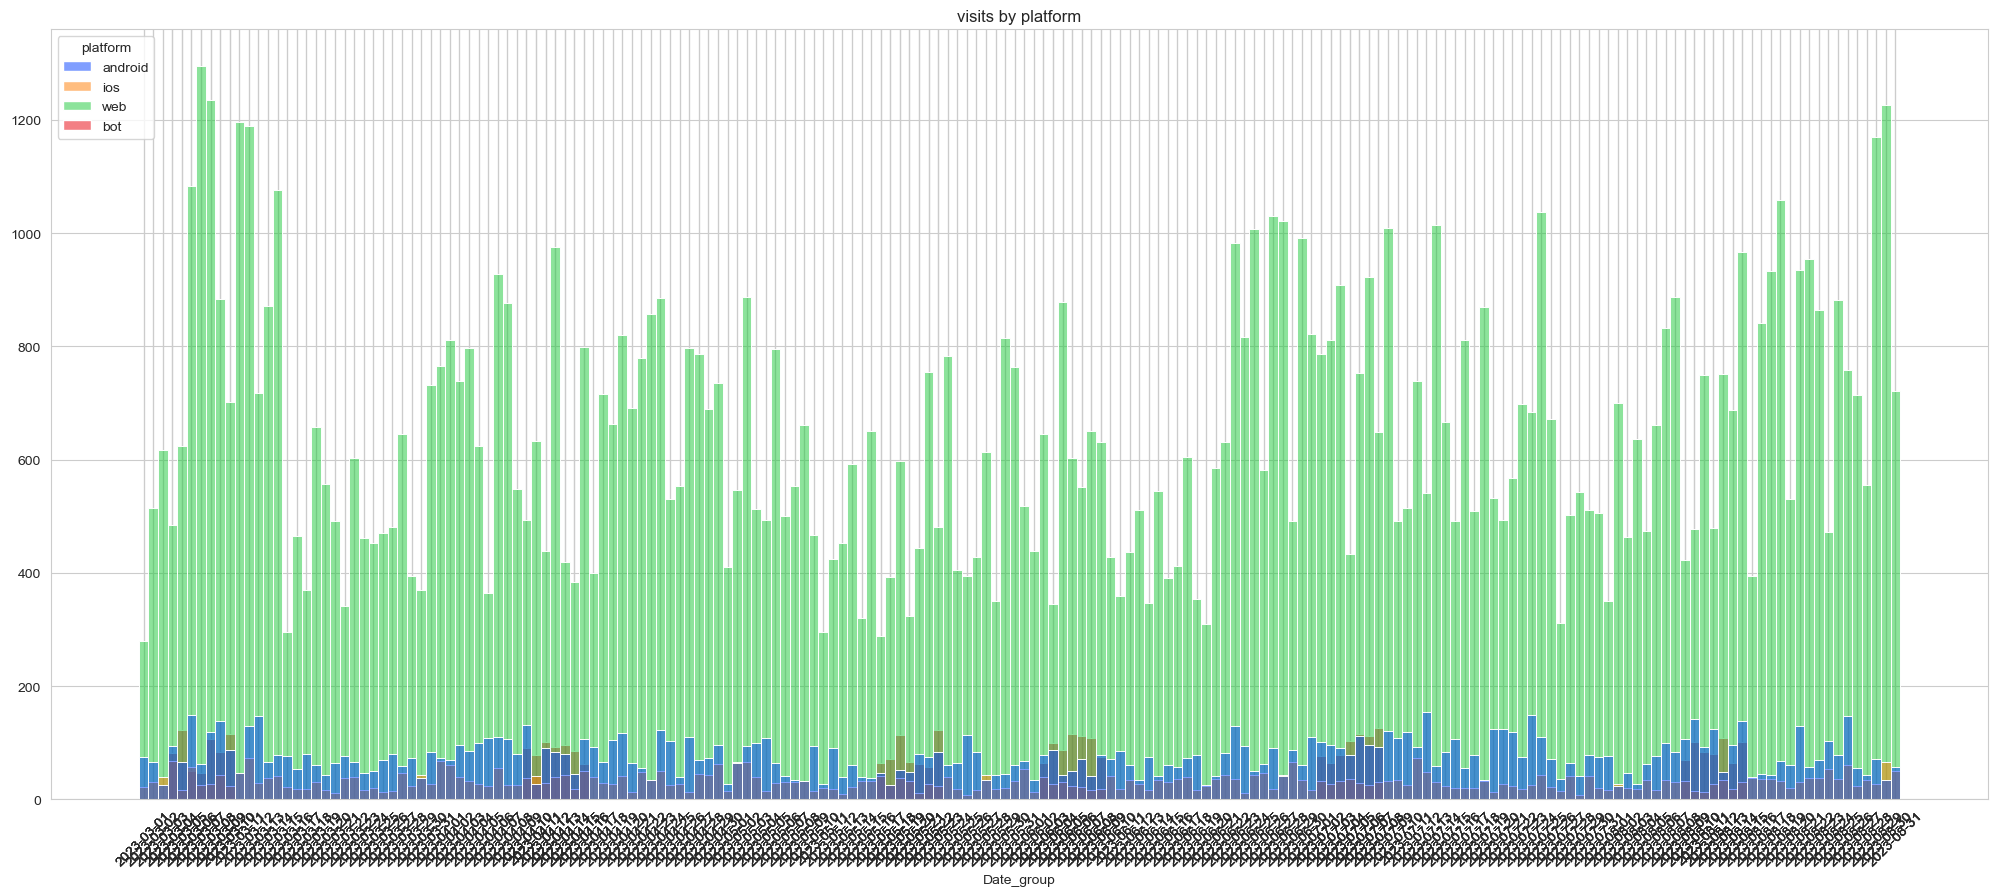

In [552]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(x='date_group', weights='visits', hue='platform', data=df_join, palette="bright")
sns.set_style("whitegrid")
plt.xticks(df_join['date_group'], rotation=45)
plt.xlabel('Date_group')
plt.ylabel('')
plt.title('visits by platform')
plt.savefig('./charts/visits_by_platform.png')

# Итоговые визиты с разбивкой по платформам

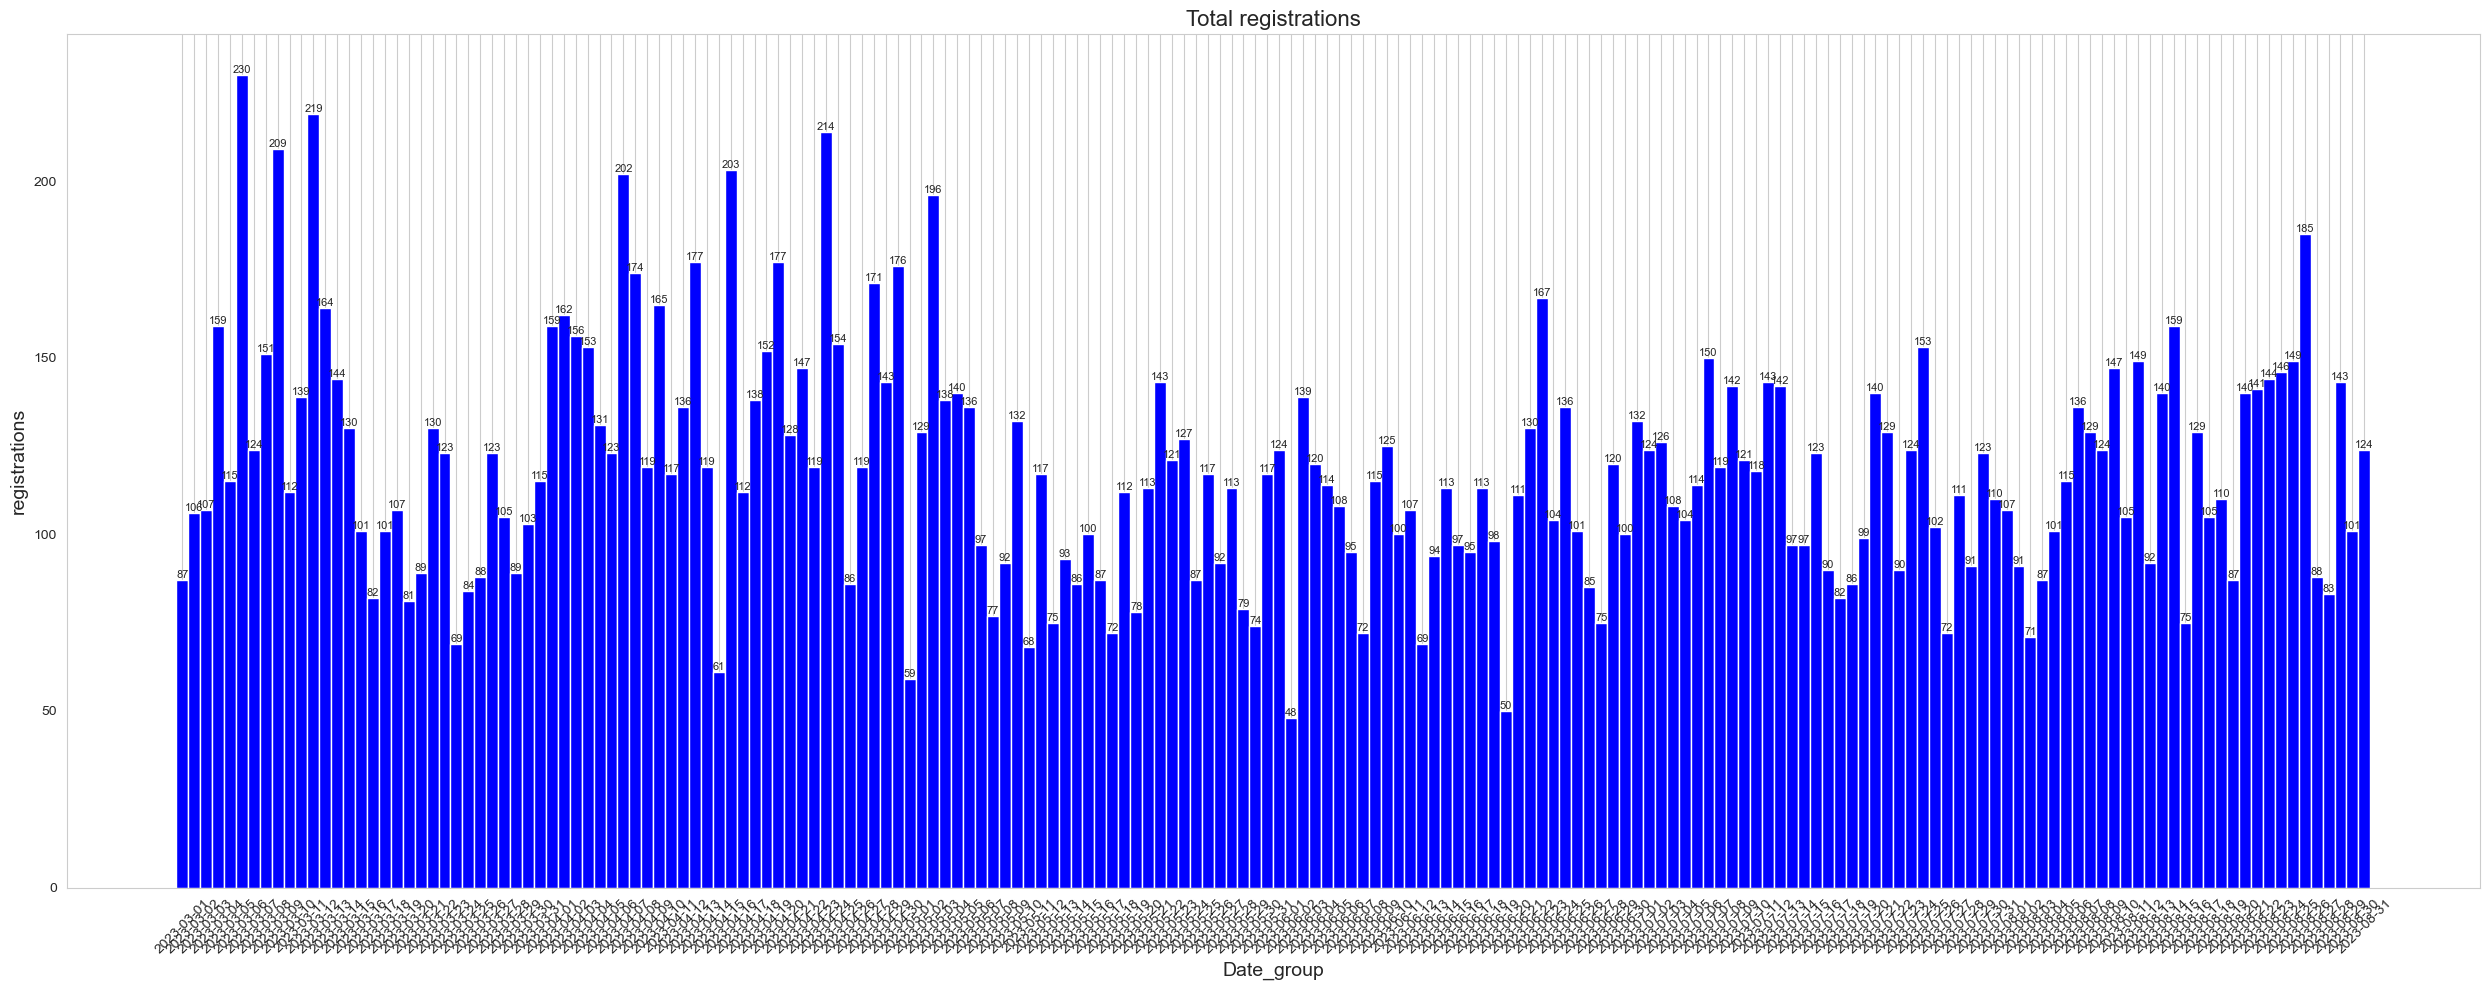

In [555]:
fig, ax = plt.subplots(figsize=(25,10))
bars = plt.bar(x='date_group', height='registrations', data=df_join_ads, width=1, color='blue')
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('Total registrations', fontsize=16)
plt.xlabel('Date_group', fontsize=14)
plt.ylabel('registrations', fontsize=14)
plt.xticks(df_join_ads['date_group'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("./charts/total_registrations.png")

# Итоговые регистрации

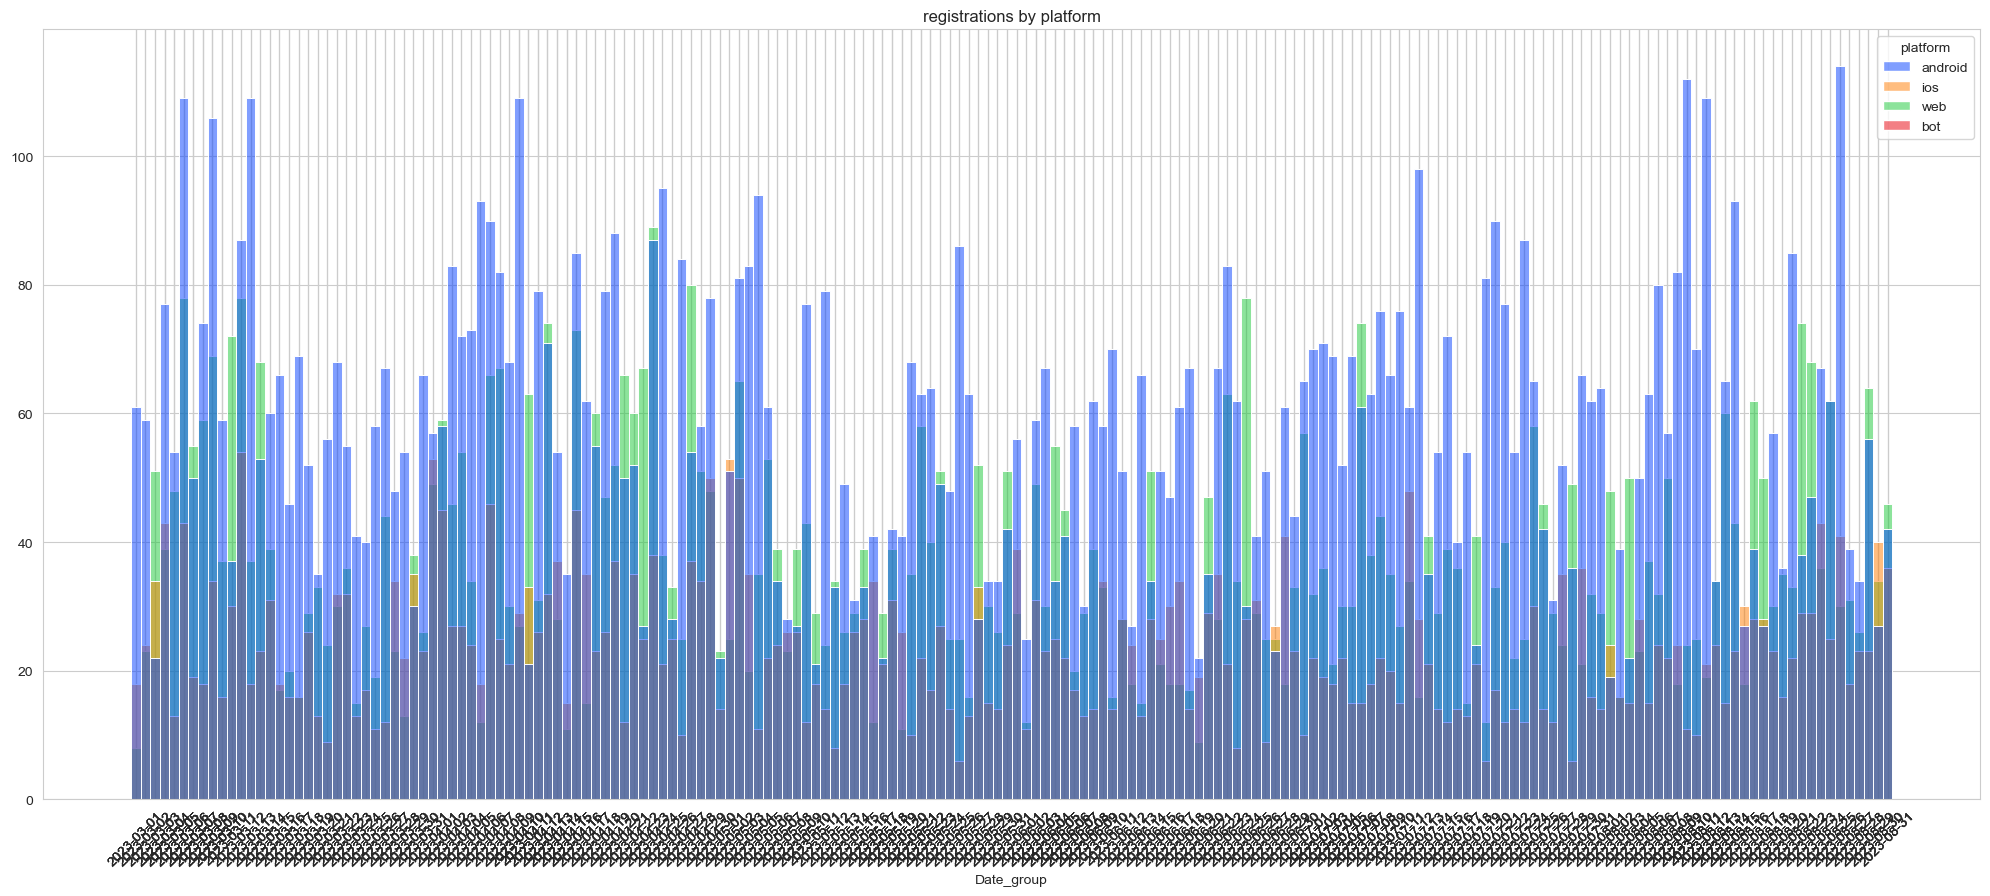

In [556]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(x='date_group', weights='registrations', hue='platform', data=df_join, palette="bright")
sns.set_style("whitegrid")
plt.xticks(df_join['date_group'], rotation=45)
plt.xlabel('Date_group')
plt.ylabel('')
plt.title('registrations by platform')
plt.savefig('./charts/registrations_by_platform.png')

# Итоговые регистрации с разбивкой по платформе

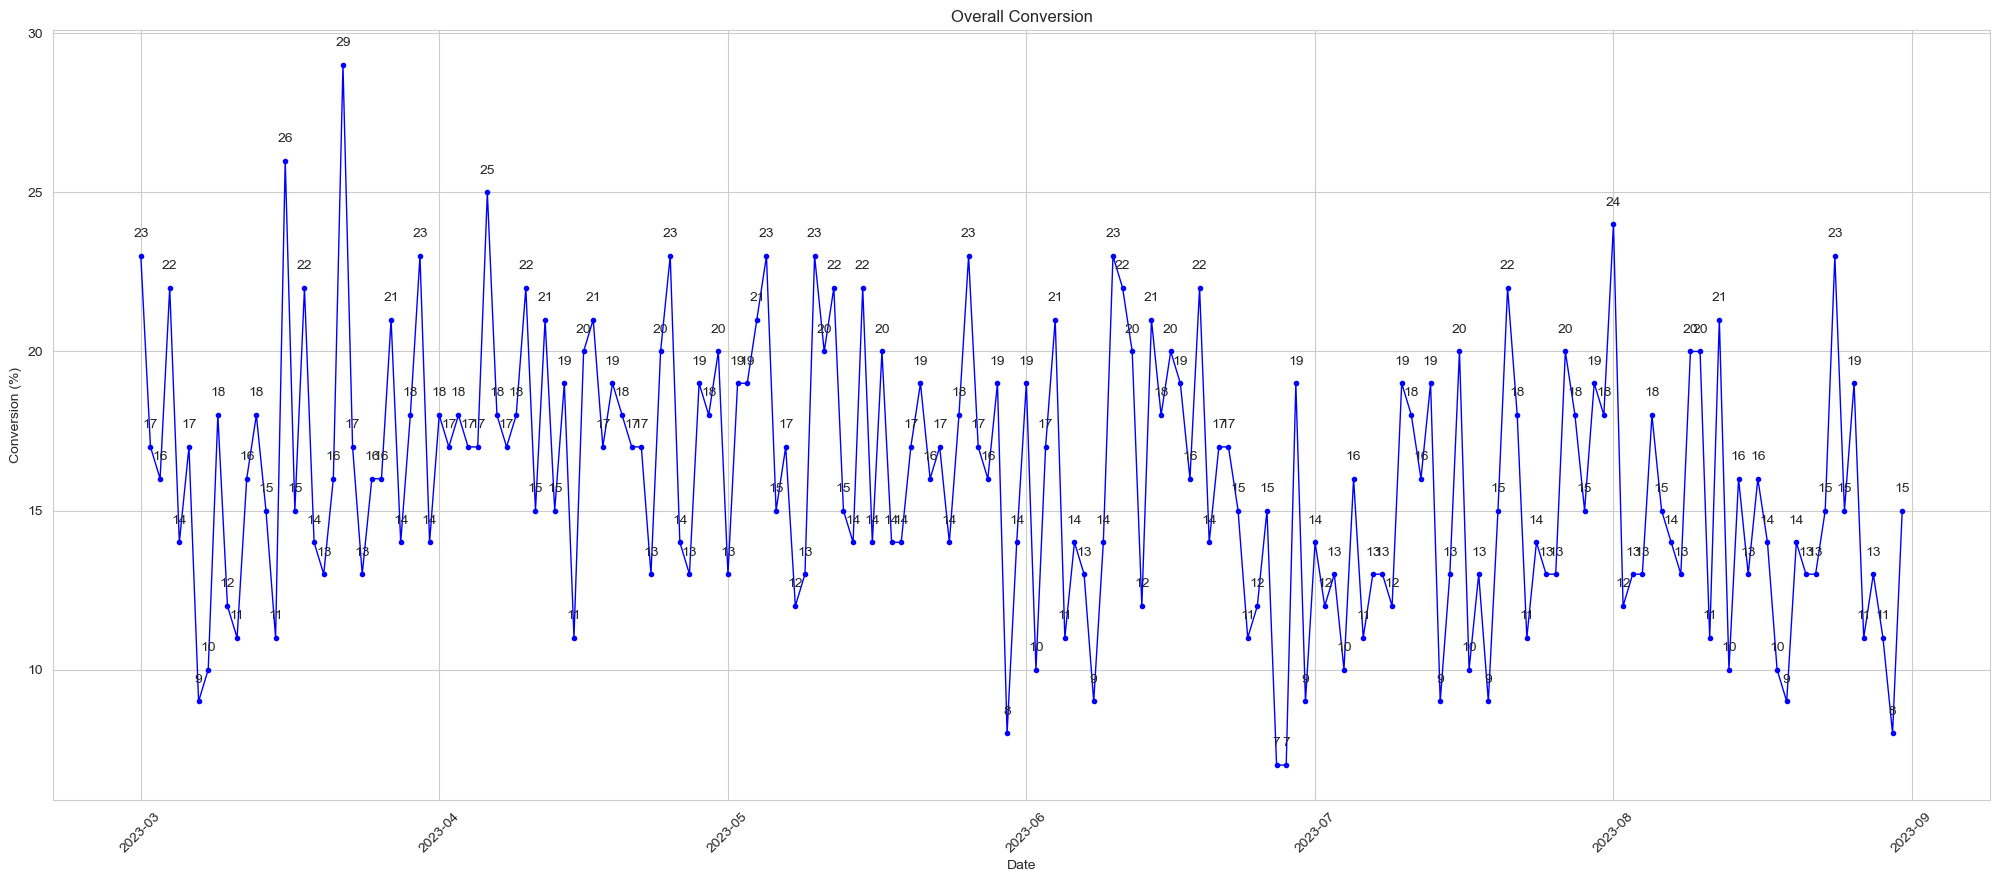

In [557]:
df_join_date['conversion'] = round((df_join_date['registrations'] / df_join_date['visits']) * 100, 0)

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df_join_date['date_group'], df_join_date['conversion'], color='blue', marker='o', linewidth=1, markersize=3)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.xticks(rotation=45)
plt.grid()
for x, y in zip(df_join_date['date_group'], df_join_date['conversion']):
    plt.text(x, y + 0.5, '%d' % y, ha='center', va = 'bottom')
plt.savefig('./charts/overall_conversion.png')

# Средняя конверсия

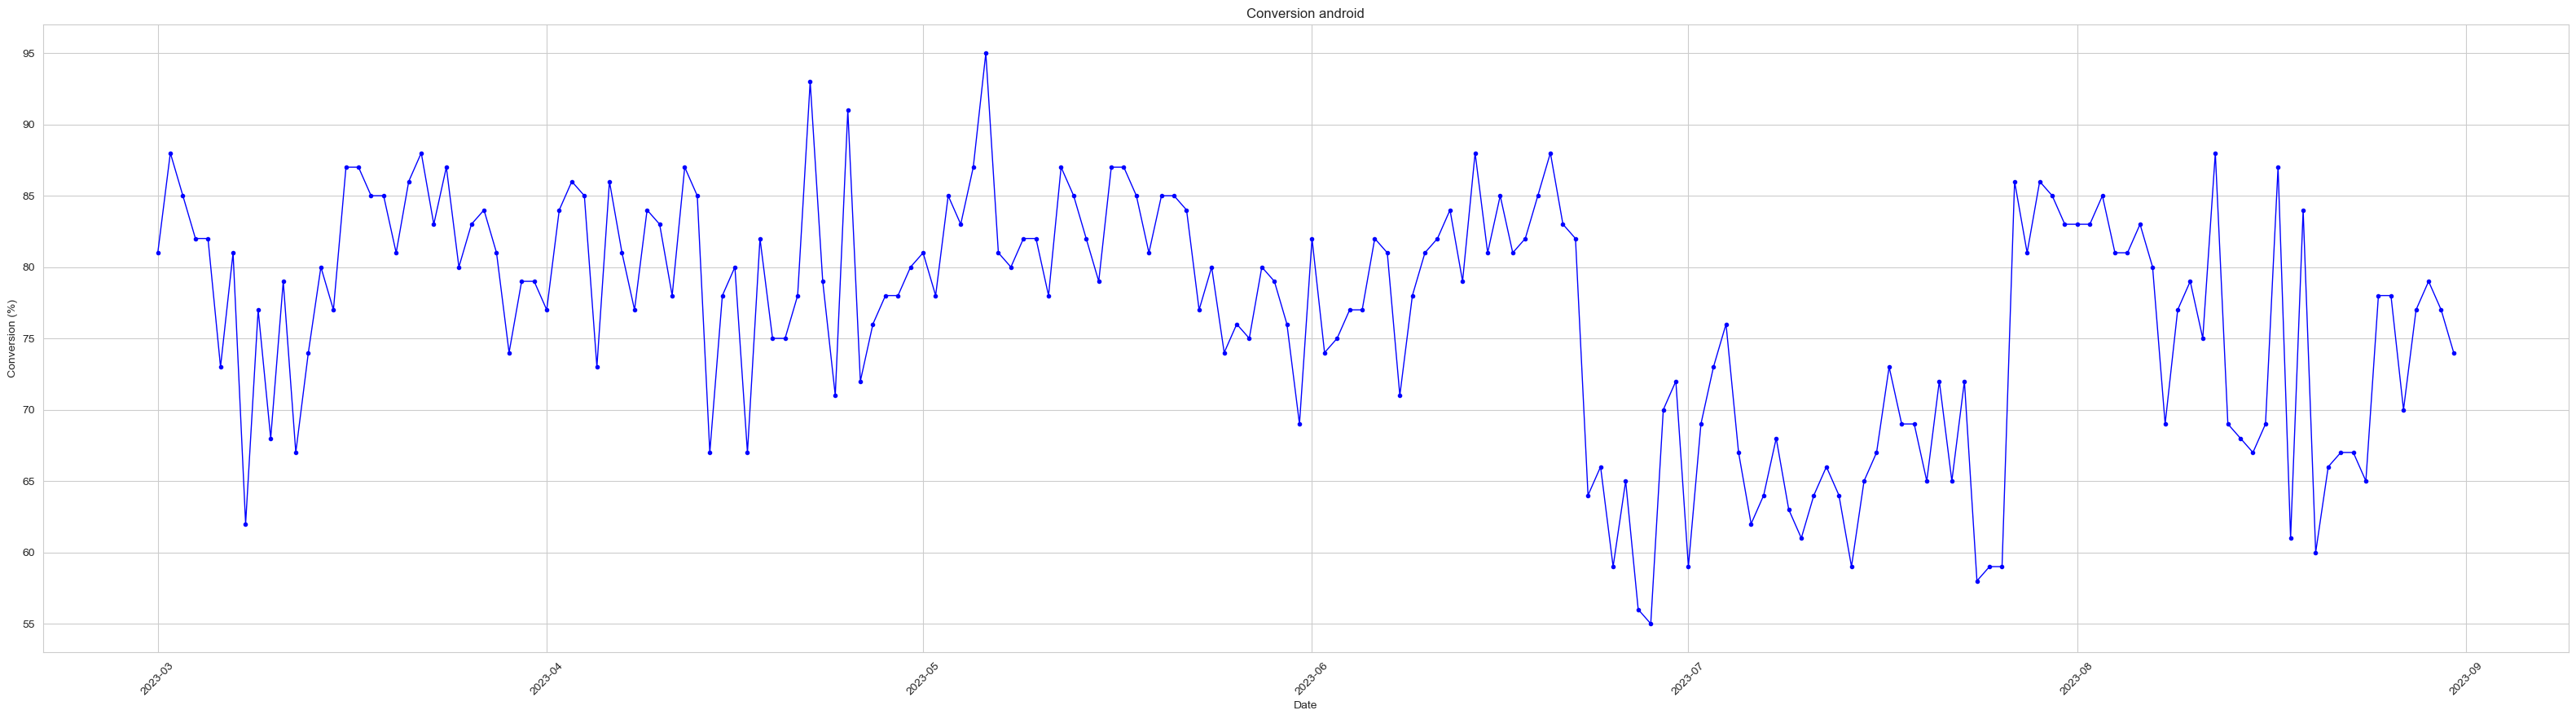

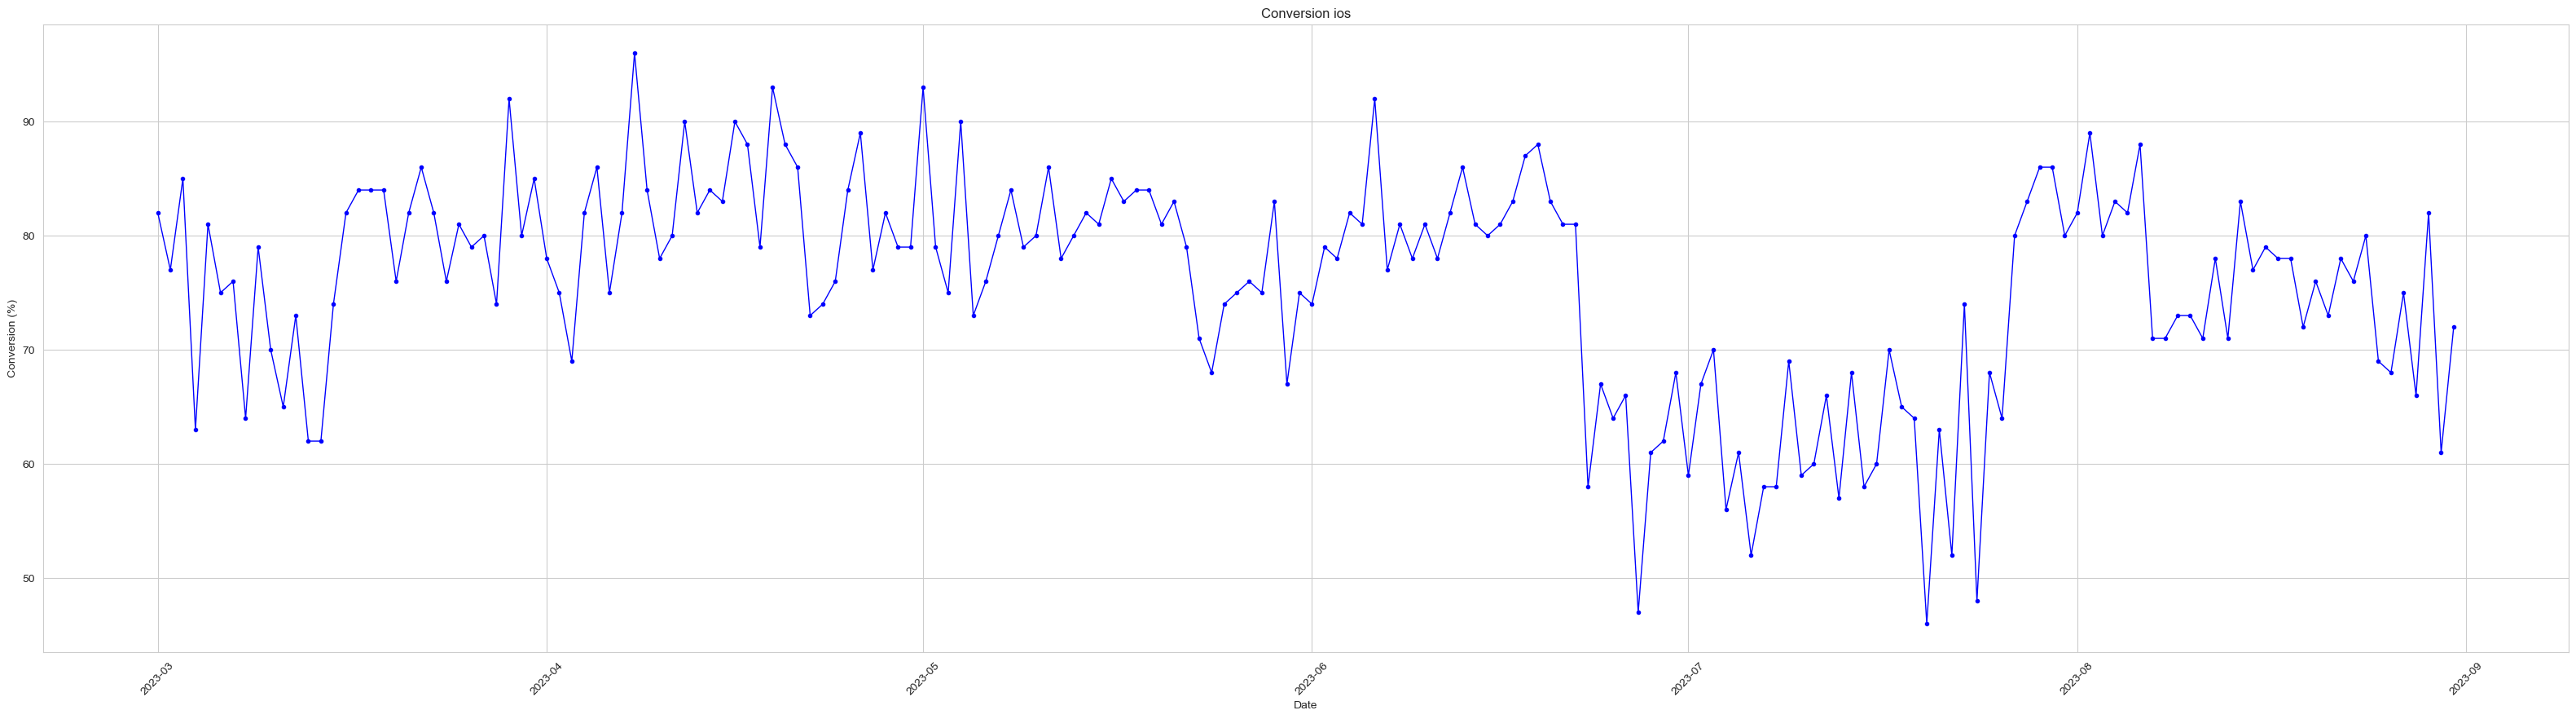

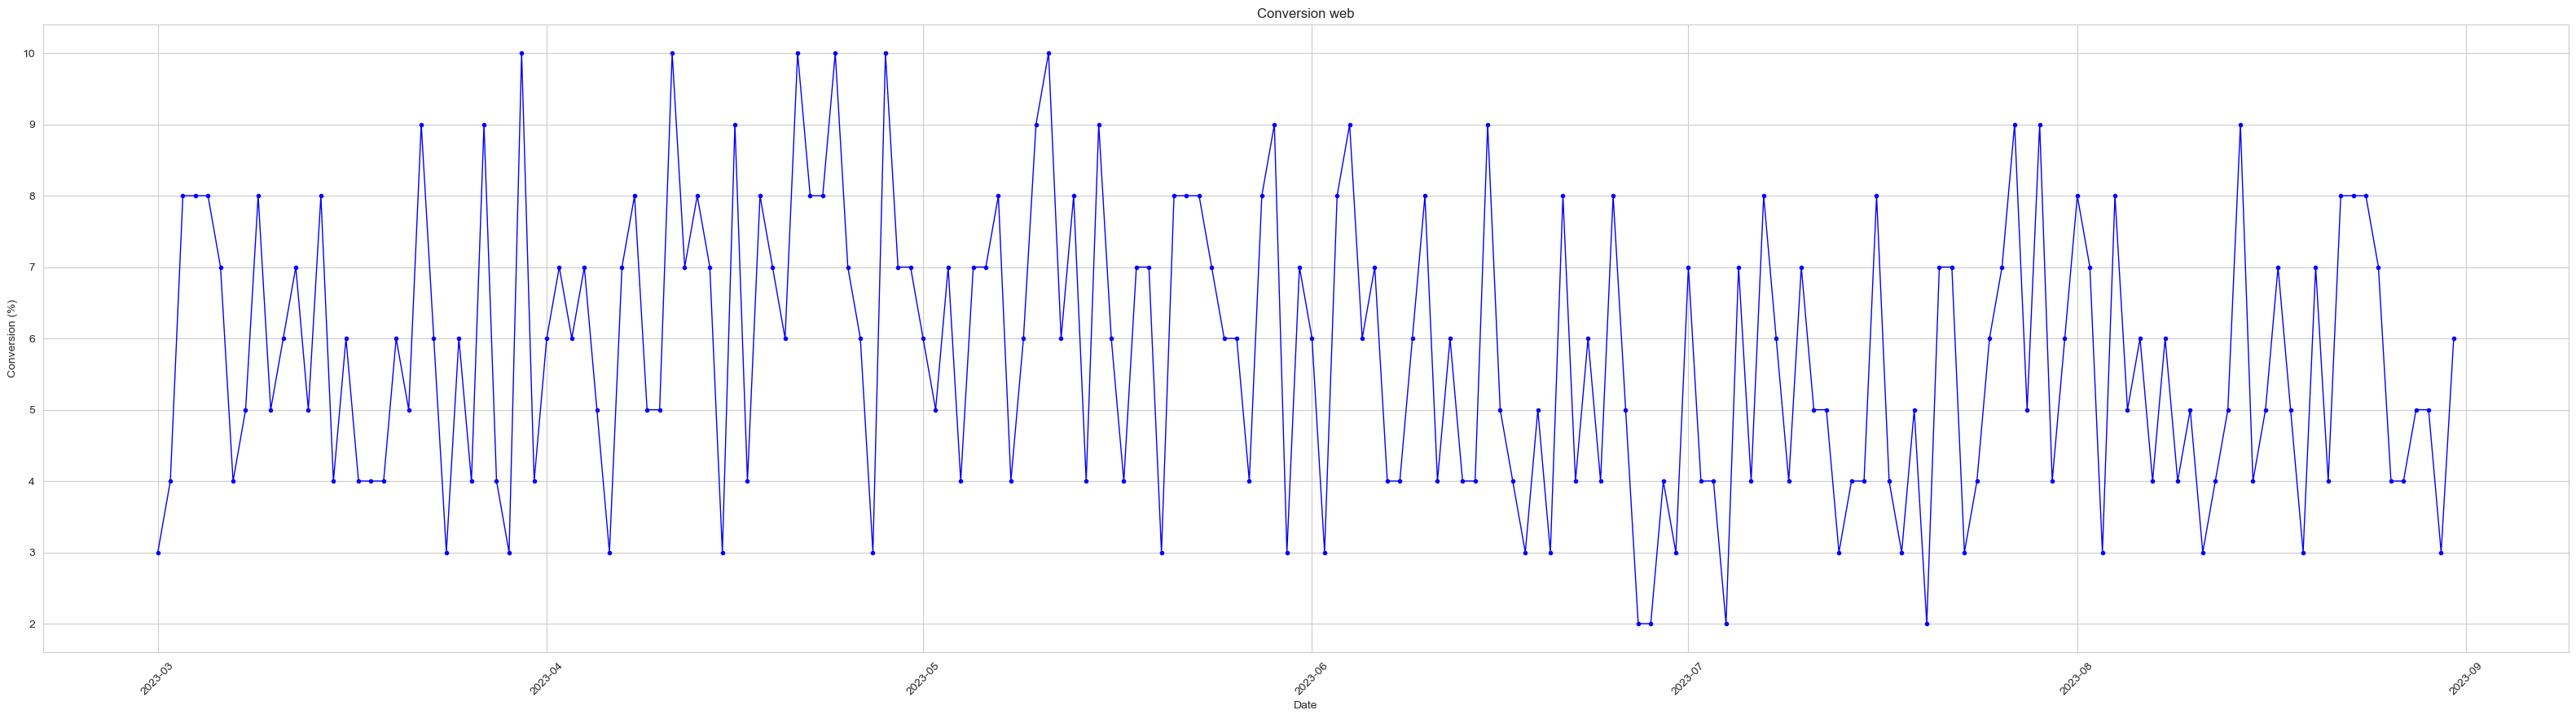

In [558]:
def platform_conversion(platform, df):
    df = df[df['platform'] == platform]

    fig, ax = plt.subplots(figsize=(40, 10))
    ax.plot(df['date_group'], df['conversion'], color='blue', marker='o', linewidth=1, markersize=3)
    ax.grid()
    ax.set_xlabel('Date')
    ax.set_ylabel('Conversion (%)')
    plt.title(f'Conversion {platform}')
    plt.xticks(rotation=45)
    plt.grid()

    plt.savefig(f"./charts/Conversion {platform}.png")
    
platform_conversion('android', df_join)
platform_conversion('ios', df_join)
platform_conversion('web', df_join)

# Конверсия по каждой платформе

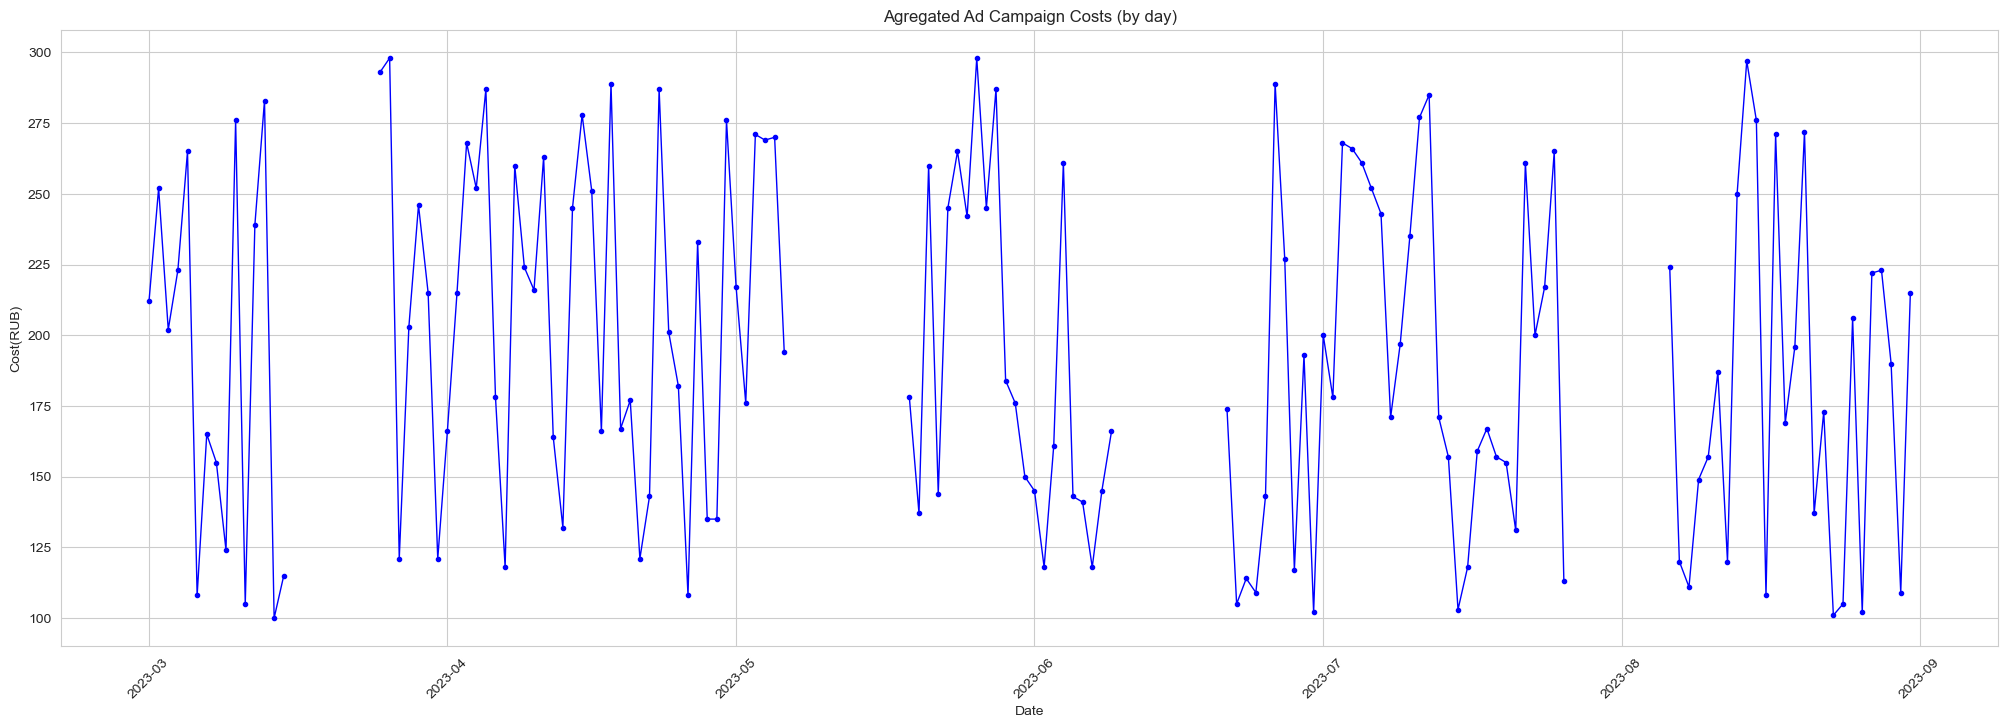

In [561]:
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(df_join_ads['date_group'], df_join_ads['cost'], color='blue', marker='o', linewidth=1, markersize=3)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Cost(RUB)')
plt.title('Agregated Ad Campaign Costs (by day)')
plt.xticks(rotation=45)
plt.grid()

plt.savefig('./charts/Agregated_Ad_Campaign_Costs_(by_day).png')

# Стоимость рекламы


In [560]:
utm_visits_count = df_join_ads.groupby(['date_group', 'utm_campaign']).agg({'visits':'sum'}).reset_index()
# print(utm_visits_count)

ads_periods = utm_visits_count[['utm_campaign', 'date_group']].groupby('utm_campaign').apply(lambda x : x.loc[(x['date_group'] == x['date_group'].min()) | (x['date_group'] == x['date_group'].max())]).reset_index(drop=True)
# print(ads_periods)

ads_start = ads_periods.groupby('utm_campaign')['date_group'].agg('min').reset_index()
ads_start.columns = ['utm_campaign', 'start'] 

ads_end = ads_periods.groupby('utm_campaign')['date_group'].agg('max').reset_index()
ads_end.columns = ['utm_campaign', 'end'] 

ads_from_start_to_end = ads_start.merge(ads_end)
ads_from_start_to_end['start'] = pd.to_datetime(ads_from_start_to_end['start'], format='%Y-%m-%d')
ads_from_start_to_end['end'] = pd.to_datetime(ads_from_start_to_end['end'], format='%Y-%m-%d')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-06'],'2023-04-05')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-08'],'2023-04-09')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-07-28'],'2023-07-29')

# Подготовка данных для графика

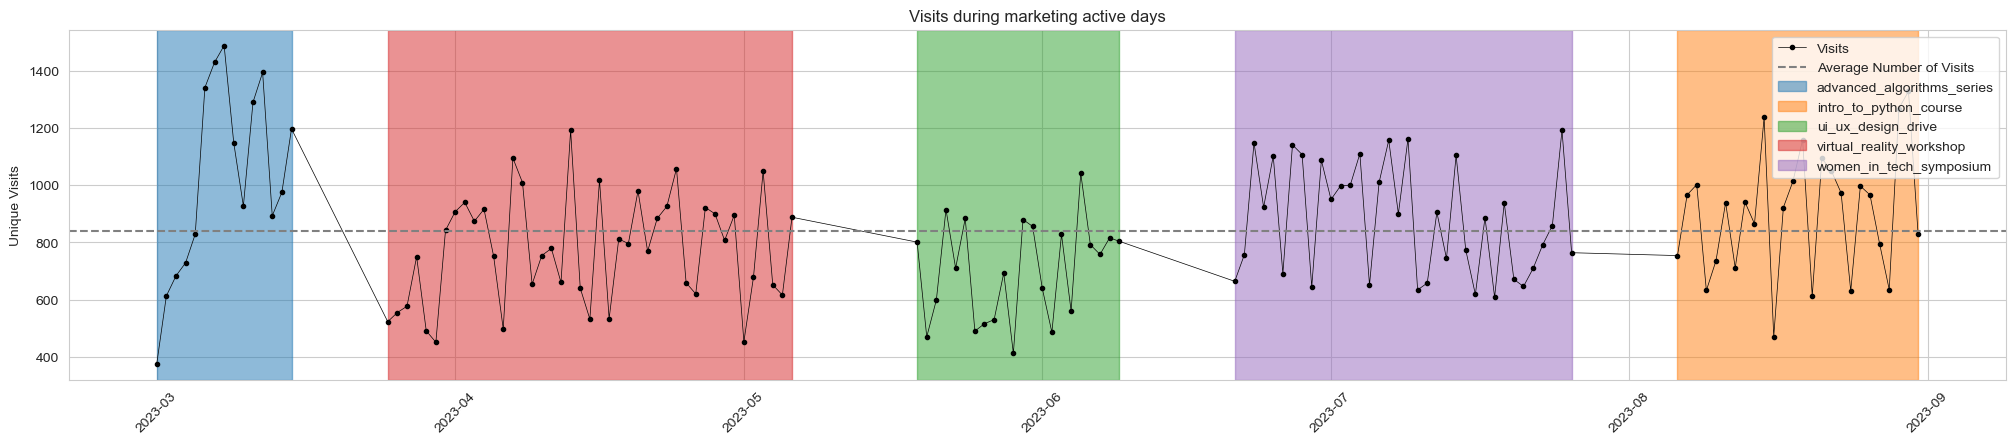

In [562]:
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
plt.title('Visits during marketing active days')
plt.xlabel('')
plt.ylabel('Unique Visits')
plt.xticks(rotation=45)
plt.plot(utm_visits_count['date_group'], utm_visits_count['visits'], color='black', label='Visits',
         marker='o', linewidth=0.5, ms=3)
plt.legend(loc='upper center')
plt.axhline(y=utm_visits_count['visits'].mean(), color='gray', linestyle='--', label="Average Number of Visits")
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), mpl.colors.TABLEAU_COLORS))
plt.legend(loc='upper right')
for _, row in ads_from_start_to_end.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.legend(loc='upper right')
plt.savefig('./charts/Visits_during_marketing_active_days.png')

# Визиты за весь период с цветовым выделением рекламной кампании

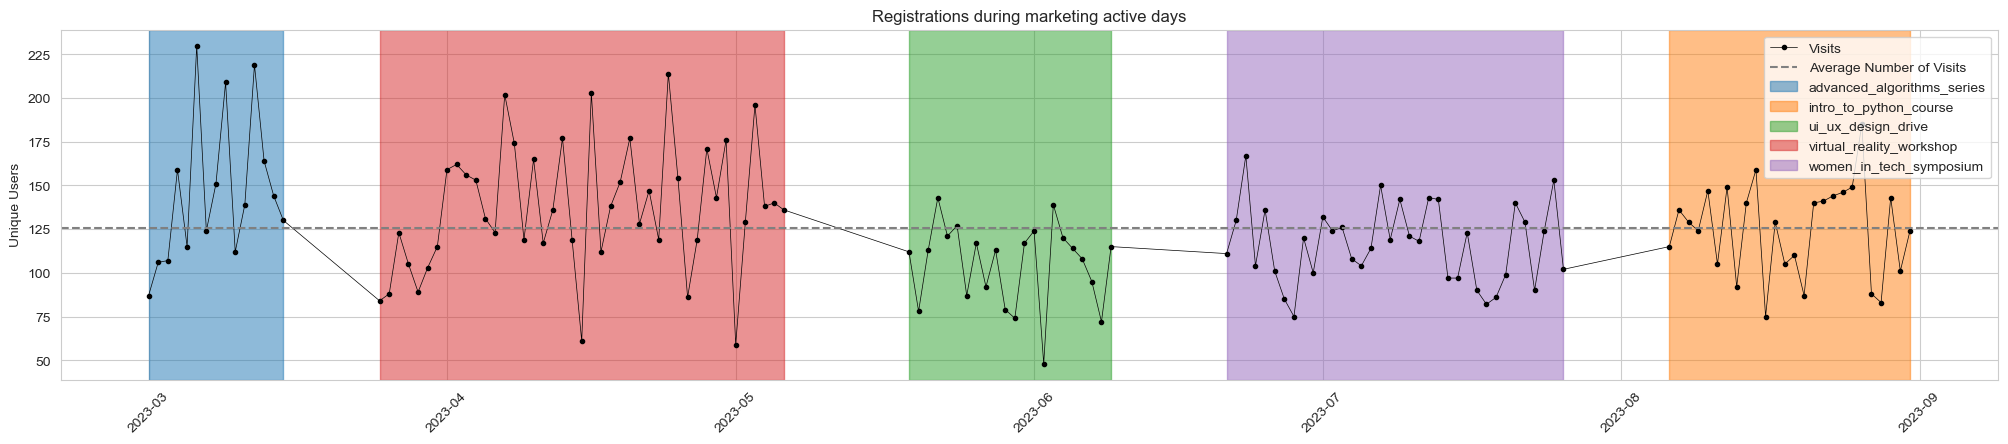

In [563]:
utm_visits_count = df_join_ads.groupby(['date_group', 'utm_campaign']).agg({'registrations':'sum'}).reset_index()

plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
plt.title('Registrations during marketing active days')
plt.xlabel('')
plt.ylabel('Unique Users')
plt.xticks(rotation=45)
plt.plot(utm_visits_count['date_group'], utm_visits_count['registrations'], color='black', label='Visits',
         marker='o', linewidth=0.5, ms=3)
plt.legend(loc='upper right')
plt.axhline(y=utm_visits_count['registrations'].mean(), color='gray', linestyle='--', label="Average Number of Visits")
plt.legend(loc='upper right')
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), mpl.colors.TABLEAU_COLORS))
for _, row in ads_from_start_to_end.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.legend(loc='upper right')
plt.savefig('./charts/Registrations_during_marketing_active_days.png')

# Регистрации за весь период с цветовым выделением рекламной кампании